In [3]:
import zipfile
import os

# data 파일 가져와서 압축해제했음
def extract_zip_in_place(zip_path):
    extract_to = os.path.dirname(zip_path)
    
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        all_files = zip_ref.namelist()
        valid_files = [f for f in all_files if not f.startswith("__MACOSX")]
        
        zip_ref.extractall(path=extract_to, members=valid_files)
    
    print(f"Extracted files in place: {extract_to}")

zip_path = "j_fashion_mnist.zip"

extract_zip_in_place(zip_path)

Extracted files in place: 


### 문제 1. mean, std 구하기

In [7]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def calculate_mean_std(dataset):
    """
    전체 데이터셋의 채널별 평균과 표준편차를 계산하는 함수.
    """
    loader = DataLoader(dataset, batch_size=256, shuffle=False)
    mean_sum = 0
    std_sum = 0
    total_images = 0

    for images, _ in loader:
        batch_images = images.size(0)  # 현재 배치의 이미지 개수
        total_images += batch_images

        # 채널별 평균과 표준편차 계산 후 누적
        mean_sum += images.mean([0, 2, 3]) * batch_images  # 채널별 평균 계산
        std_sum += images.std([0, 2, 3]) * batch_images    # 채널별 표준편차 계산

    # 전체 이미지 개수를 사용해 최종 평균과 표준편차 계산
    mean = mean_sum / total_images
    std = std_sum / total_images

    return mean.item(), std.item()

# Fashion MNIST 데이터셋 설정
transform = transforms.ToTensor()  # 데이터를 텐서 형태로 변환
dataset = datasets.FashionMNIST(root='./j_fashion_mnist', train=True, download=False, transform=transform)

# 평균 및 표준편차 계산
mean, std = calculate_mean_std(dataset)

# 결과 출력
print(f"Mean: {mean:.6f}, Std: {std:.6f}")

Mean: 0.286041, Std: 0.352897


### 과제 2.  Validation Accuracy 출력 및 모델 학습하기

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import wandb
import random

# Wandb 초기화
wandb.init(project="fashion-mnist-cnn")

# CNN 모델 정의
class FashionMNIST_CNN(nn.Module):
    def __init__(self):
        super(FashionMNIST_CNN, self).__init__()

        # Feature Extraction Layers
        # 첫 번째 컨볼루션 레이어: 입력 채널 1개, 출력 채널 32개, 커널 크기 3, 각 나머지 Stride 및 Padding은 1개
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        # 배치 정규화 적용
        self.bn1 = nn.BatchNorm2d(32)  
        # 두 번째 컨볼루션 레이어: 입력 채널 32개, 출력 채널 64개, 커널 크기 3, 각 나머지 Stride 및 Padding은 1개
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # 배치 정규화 적용
        self.bn2 = nn.BatchNorm2d(64)
        # MaxPooling -> kernel_size를 2로 설정하고 stride를 2로 설정하여 크기를 절반으로 감소시킴 (28*28 -> 14*14)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) 

        # 세 번째 컨볼루션 레이어: 입력 채널 64개, 출력 채널 128개, 커널 크기 3, 각 나머지 Stride 및 Padding은 1개
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        # 배치 정규화 적용
        self.bn3 = nn.BatchNorm2d(128)
        # MaxPooling -> kernel_size를 2로 설정하고 stride를 2로 설정하여 크기를 절반으로 감소시킴 (14*14 -> 7*7)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 네 번째 컨볼루션 레이어: 입력 채널 128개, 출력 채널 256개, 커널 크기 3, 각 나머지 Stride 및 Padding은 1개
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        # 배치 정규화 적용
        self.bn4 = nn.BatchNorm2d(256)

        # Adaptive Pooling Layer: 모든 입력을 3x3 크기로 변환
        self.adaptive_pool = nn.AdaptiveAvgPool2d((3, 3))

        # Fully Connected Layers
        # 256 채널 * 3x3 크기, 위에서 받은 입력 AvgPooling 크기를 이용
        self.fc1 = nn.Linear(256 * 3 * 3, 512)
        # 배치 정규화 적용
        self.bn_fc1 = nn.BatchNorm1d(512)
        # 드롭아웃 설정, 과적합 방지 -> 0.35가 적당하다고 판단(다양한 계수 넣어보며 판단)
        self.dropout = nn.Dropout(0.35)  
        # 512 채널 -> 128 채널로 감소
        self.fc2 = nn.Linear(512, 128)
        # 배치 정규화 적용
        self.bn_fc2 = nn.BatchNorm1d(128)
        # Fashion MNIST의 클래스 수를 따라 128개의 채널에서 10개의 채널로 감소
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        # 첫 번째 컨볼루션 -> 배치 정규화 -> ReLU -> 풀링
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))  
        # 두 번째 컨볼루션, 상단과 동일
        x = self.pool1(F.relu(self.bn2(self.conv2(x)))) 
        # 세 번째 컨볼루션, 상단과 동일
        x = self.pool2(F.relu(self.bn3(self.conv3(x))))
        # 네 번째 컨볼루션 -> Adaptive Pooling
        x = self.adaptive_pool(F.relu(self.bn4(self.conv4(x))))  

        # Fully Connected Layers에 입력하기 위해 데이터 형태를 1차원으로 변환
        x = x.view(x.size(0), -1)

        # Fully Connected Layers
        # 첫 번째 FC -> ReLU -> 배치 정규화
        x = F.relu(self.bn_fc1(self.fc1(x)))  
        # 드롭아웃 적용(과적합 방지)
        x = self.dropout(x)
        # 두 번째 FC
        x = F.relu(self.bn_fc2(self.fc2(x)))
        # 최종 출력 FC
        x = self.fc3(x)  
        return x

# 데이터 로드 및 전처리
def get_fashion_mnist_data(mean, std):
    transform = transforms.Compose([
        # 랜덤 크롭
        transforms.RandomCrop(28, padding=2), 
        # 랜덤 좌우 뒤집기
        transforms.RandomHorizontalFlip(),
        # 랜덤 위아래 뒤집기
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),                
        transforms.Normalize((mean,), (std,))
    ])

    # Train과 Validation, Test Dataset을 설정
    full_train_dataset = datasets.FashionMNIST(root='./j_fashion_mnist', train=True, download=True, transform=transform)
    test_dataset = datasets.FashionMNIST(root='./j_fashion_mnist', train=False, download=True, transform=transform)

    # Train과 Validation 데이터셋 분리
    train_dataset, val_dataset = random_split(full_train_dataset, [55000, 5000])

    # DataLoader 생성, Validation과 test에서는 shuffle X
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)   
    val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)   

    return train_loader, val_loader, test_loader


def do_train(model, train_loader, criterion, optimizer, device):
    # 모델을 학습 모드로 설정
    model.train()  
    
    # Loss 초기화
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  

        # 모델의 출력 계산
        outputs = model(inputs)
        # 손실 계산
        loss = criterion(outputs, labels)  

        # 최적화 과정
        optimizer.zero_grad()  
        loss.backward()       
        optimizer.step()       

        # train_loss 누적
        running_loss += loss.item()  

        # 정확도 계산
        _, predicted = torch.max(outputs, 1)  # 가장 높은 확률의 클래스 선택
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # 평균 train loss 계산
    avg_loss = running_loss / len(train_loader) 
    # 훈련 정확도 계산
    train_accuracy = 100 * correct / total

    # Wandb에 로깅
    wandb.log({"train_loss": avg_loss, "train_accuracy": train_accuracy}) 
    
    return avg_loss, train_accuracy


# 검증 함수
def do_validation(model, validation_loader, criterion, device):
    # 평가 모드로 전환 
    model.eval()  

    # 각 loss와 맞춘 갯수와 총 갯수 초기화
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # 그래디언트 계산 비활성화
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # 정확도 계산
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # 평균 loss 계산 및 정확도 계산
    avg_loss = val_loss / len(validation_loader)
    val_accuracy = 100 * correct / total

    # Wandb에 로깅
    wandb.log({"val_loss": avg_loss, "val_accuracy": val_accuracy})
    return avg_loss, val_accuracy


# 테스트 함수
def test_model(model, test_loader, device):
    # 모델을 평가 모드로 설정
    model.eval() 
    
    # 테스트에서 맞춘 갯수와 총 갯수 초기화
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1) 
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # 정확도 계산
    accuracy = 100 * correct / total  
    # Wandb에 로깅
    wandb.log({"test_accuracy": accuracy})  
    return accuracy

# 메인 실행
if __name__ == "__main__":
    # 데이터셋 평균 및 표준편차
    mean = 0.286041
    std = 0.352897
    
    # 가장 높은 validaion, test accuracy 저장
    best_val_accuracy = 0.0
    best_test_accuracy = 0.0

    # 데이터 로드
    train_loader, validation_loader, test_loader = get_fashion_mnist_data(mean, std)

    # 장치 설정, GPU를 사용하므로 device는 cuda
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # 모델 초기화 단계
    # 모델을 GPU로 이동
    model = FashionMNIST_CNN().to(device)  
    # 손실 함수는 CrossEntropyLoss를 사용
    criterion = nn.CrossEntropyLoss()  
    # Optimizer는 AdamW를 사용하였음, Learning Late는 0.0006 설정, weight_dacay는 0.001)
    # 기존에 사용하던 AdamW를 사용하면 가중치를 제어해주며 Fashion MNIST에서는 나은 결과를 보여줄 수 있다고 함
    optimizer = optim.AdamW(model.parameters(), lr=0.0006, weight_decay=1e-3)
    # 스케줄러를 사용했는데, 일정 validation loss가 감소하지 않으면 lr을 반으로 감소시키도록 하였음
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    # 100 epoch만큼 학습 및 검증, 테스트 진행
    for epoch in range(1, 121):
        print(f"Epoch {epoch}: ")
    
        # 학습 진행
        train_loss, train_accuracy = do_train(model, train_loader, criterion, optimizer, device)  
        # 검증 진행
        val_loss, val_accuracy = do_validation(model, validation_loader, criterion, device) 
        # 테스트 진행
        test_accuracy = test_model(model, test_loader, device)
        # 스케줄러 업데이트
        scheduler.step(val_loss)
    
        # 각 Loss, Accuracy를 출력하도록 함
        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.3f}%, Val Accuracy: {val_accuracy:.3f}%, Test Accuracy: {test_accuracy:.3f}%")

        # 가장 높은 Validation Accuracy 갱신
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            # 아래 4번 과제를 위해 모델 저장
            torch.save(model.state_dict(), "best_model.pth") 
            print(f"최고 Validation Accuracy 갱신! Best Val Accuracy: {best_val_accuracy:.3f}%")
    
        # 가장 높은 Test Accuracy 갱신
        if test_accuracy > best_test_accuracy:
            best_test_accuracy = test_accuracy
            print(f"최고 Test Accuracy 갱신! Best Test Accuracy: {best_test_accuracy:.3f}%")

    print(f"Best Validation Accuracy: {best_val_accuracy:.3f}%")
    print(f"Best Test Accuracy: {best_test_accuracy:.3f}%")

test_accuracy,▁▃█▃
train_accuracy,▁▆▇█
train_loss,█▃▂▁
val_accuracy,▁▃█▅
val_loss,█▅▁▃
test_accuracy,84.26
train_accuracy,87.41273
train_loss,0.34168
val_accuracy,85.8
val_loss,0.38075


Epoch 1: 
Train Loss: 0.6315, Val Loss: 0.4666, Train Accuracy: 78.718%, Val Accuracy: 83.220%, Test Accuracy: 83.000%
최고 Validation Accuracy 갱신! Best Val Accuracy: 83.220%
최고 Test Accuracy 갱신! Best Test Accuracy: 83.000%
Epoch 2: 
Train Loss: 0.4121, Val Loss: 0.4082, Train Accuracy: 85.109%, Val Accuracy: 85.500%, Test Accuracy: 85.380%
최고 Validation Accuracy 갱신! Best Val Accuracy: 85.500%
최고 Test Accuracy 갱신! Best Test Accuracy: 85.380%
Epoch 3: 
Train Loss: 0.3633, Val Loss: 0.3656, Train Accuracy: 86.576%, Val Accuracy: 86.480%, Test Accuracy: 86.000%
최고 Validation Accuracy 갱신! Best Val Accuracy: 86.480%
최고 Test Accuracy 갱신! Best Test Accuracy: 86.000%
Epoch 4: 
Train Loss: 0.3377, Val Loss: 0.3538, Train Accuracy: 87.560%, Val Accuracy: 87.400%, Test Accuracy: 86.780%
최고 Validation Accuracy 갱신! Best Val Accuracy: 87.400%
최고 Test Accuracy 갱신! Best Test Accuracy: 86.780%
Epoch 5: 
Train Loss: 0.3167, Val Loss: 0.3449, Train Accuracy: 88.371%, Val Accuracy: 87.820%, Test Accuracy: 8

Train Loss: 0.1288, Val Loss: 0.1836, Train Accuracy: 95.180%, Val Accuracy: 93.980%, Test Accuracy: 92.680%
최고 Validation Accuracy 갱신! Best Val Accuracy: 93.980%
Epoch 53: 
Train Loss: 0.1284, Val Loss: 0.1909, Train Accuracy: 95.236%, Val Accuracy: 93.500%, Test Accuracy: 92.830%
Epoch 54: 
Train Loss: 0.1294, Val Loss: 0.1893, Train Accuracy: 95.180%, Val Accuracy: 93.840%, Test Accuracy: 92.820%
Epoch 55: 
Train Loss: 0.1285, Val Loss: 0.1837, Train Accuracy: 95.282%, Val Accuracy: 93.860%, Test Accuracy: 92.920%
최고 Test Accuracy 갱신! Best Test Accuracy: 92.920%
Epoch 56: 
Train Loss: 0.1251, Val Loss: 0.1932, Train Accuracy: 95.318%, Val Accuracy: 93.820%, Test Accuracy: 93.080%
최고 Test Accuracy 갱신! Best Test Accuracy: 93.080%
Epoch 57: 
Train Loss: 0.1252, Val Loss: 0.1930, Train Accuracy: 95.418%, Val Accuracy: 93.960%, Test Accuracy: 93.120%
최고 Test Accuracy 갱신! Best Test Accuracy: 93.120%
Epoch 58: 
Train Loss: 0.1247, Val Loss: 0.1879, Train Accuracy: 95.376%, Val Accuracy: 93

Train Loss: 0.1091, Val Loss: 0.1823, Train Accuracy: 95.982%, Val Accuracy: 93.820%, Test Accuracy: 93.100%
Epoch 116: 
Train Loss: 0.1101, Val Loss: 0.1894, Train Accuracy: 95.904%, Val Accuracy: 94.060%, Test Accuracy: 93.230%
Epoch 117: 
Train Loss: 0.1112, Val Loss: 0.1946, Train Accuracy: 95.815%, Val Accuracy: 93.660%, Test Accuracy: 93.420%
Epoch 118: 
Train Loss: 0.1089, Val Loss: 0.1863, Train Accuracy: 95.956%, Val Accuracy: 94.140%, Test Accuracy: 93.220%
Epoch 119: 
Train Loss: 0.1112, Val Loss: 0.1869, Train Accuracy: 95.856%, Val Accuracy: 93.880%, Test Accuracy: 93.140%
Epoch 120: 
Train Loss: 0.1097, Val Loss: 0.1844, Train Accuracy: 95.965%, Val Accuracy: 94.080%, Test Accuracy: 93.240%
Best Validation Accuracy: 94.480%
Best Test Accuracy: 93.560%


### 과제 2. torchinfo.summary

In [24]:
from torchinfo import summary

# 모델 초기화 및 장치 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = FashionMNIST_CNN().to(device)

summary(model, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
FashionMNIST_CNN                         [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 28, 28]           320
├─BatchNorm2d: 1-2                       [1, 32, 28, 28]           64
├─MaxPool2d: 1-3                         [1, 32, 14, 14]           --
├─Conv2d: 1-4                            [1, 64, 14, 14]           18,496
├─BatchNorm2d: 1-5                       [1, 64, 14, 14]           128
├─MaxPool2d: 1-6                         [1, 64, 7, 7]             --
├─Conv2d: 1-7                            [1, 128, 7, 7]            73,856
├─BatchNorm2d: 1-8                       [1, 128, 7, 7]            256
├─MaxPool2d: 1-9                         [1, 128, 3, 3]            --
├─Conv2d: 1-10                           [1, 256, 3, 3]            295,168
├─BatchNorm2d: 1-11                      [1, 256, 3, 3]            512
├─AdaptiveAvgPool2d: 1-12                [1, 256, 3, 3]            -

### 과제 2. 적용한 과정 서술

수업에서 배운 다음 내용들에 소개된 기법들 최대한 활용
• 11, 12. Diverse Techniques (다양한 최적화 및 정규화 기법)
• 13. modern CNNs (다양한 CNN 모델)
– 마크다운 글 작성 방법으로 본인이 찾은 최적의 하이퍼파라미터 정리하여 제시
• Learning Rate, Batch Size
• Early Stop Patience
• Weight Decay Value
• Normalization Type
• Dropout Rate 등

• 모델 구조에서 사용한 기법
1. BatchNormaliztion : BatchNorm2d, BatchNorm1d를 이용해 정규화를 진행했고, 이 과정에서 훈련 속도와 안정성을 증가시켰음
2. Dropout : 여기선 0.35 -> 35%를 버리는 방법을 이용해 과적합을 방지했는데, 0.2부터 0.5까지 다양한 숫자를 넣어보았고, 여기서는 0.35가 가장 Accuracy가 잘 나오는 듯 하여 설정해보았음
3. AdaptiveAvgPool2d : global Average Polling을 사용했는데, 출력 크기를 일정하게 정하여 FCL에 들어가기 쉽도록 하였음

• 최적화에서 사용한 기법
1. Optimizer(AdamW) : 기존에 사용하던 Adam보다 Weight Decay가 더 잘 작동할 수 있도록 한다고 하여 사용해보았음, Weight Decay는 0.001(1e-3)을 사용하여 과적합을 방지, Learning rate는 0.0001~0.001 중 여러 번 찾아보다 적당히 0.0006을 사용하였음.
2. Scheduling : 기존에는 특정 에포크(60) 정도에 직접적으로 learning Late를 수정하였는데, 이보다 효율적인 방법을 찾다가 Scheduling을 사용해보았음. 여기선 Validation loss가 감소하지 않으면(5번 연속) learning rate를 반으로 감소시켜서 이를 사용했음.

• 이미지 처리에 사용한 기법
1. transforms.RandomCrop(28, padding=2), transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip() : 위 기법으로 이미지 일부를 없애거나, 좌우 반전을 하거나, 상하 반전을 통하여 데이터셋의 과적합을 방지하기 위한 이미지 전처리 기법을 사용했음

• 하이퍼파라미터
1. Learning Rate (초기): 0.0006
2. Batch Size: 256 -> 다양하게 64 ~ 512를 사용해보았는데, 256이 값이 잘 나와서 사용했음
3. Weight Decay: 1e-3
4. Dropout Rate: 0.35 -> 그 외 하이퍼파라미터에 대한 설명은 상단 기법에 서술해서 적지 않았음

### 과제 3. Test Accuracy 출력하기

In [19]:
# 저장된 모델 파일을 불러오기, 여기선 Validation Accuracy가 가장 높은 모델을 가져왔음
saved_model_path = "best_model.pth"
model = FashionMNIST_CNN()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
model.load_state_dict(torch.load(saved_model_path))
model.eval()

# Test Accuracy 확인
test_accuracy = test_model(model, test_loader, device)

print(f"Test Accuracy: {test_accuracy:.3f}%")

Test Accuracy: 93.080%


### 과제 4. 샘플 테스트 데이터 분류 예측 결과 확인하기

틀린 예측: 1번 index
True Label: Shirt, Predicted: Dress


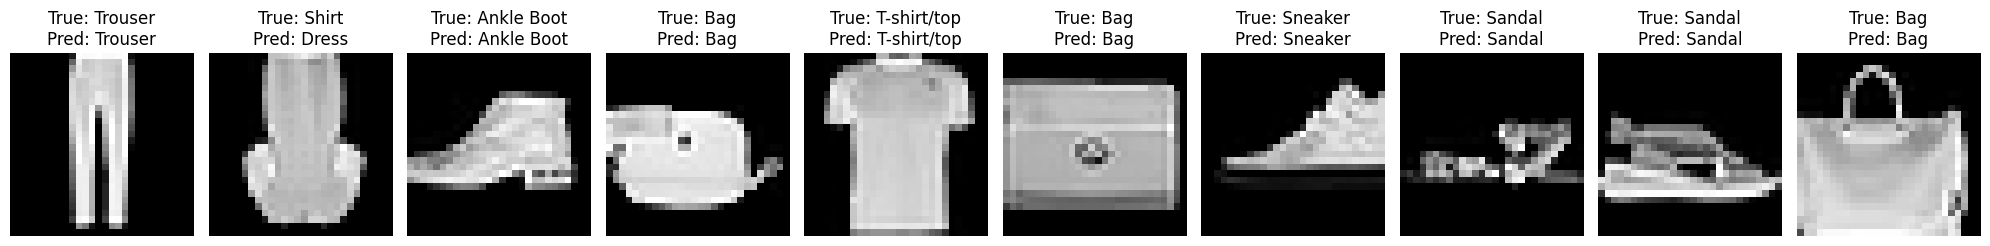

In [31]:
import matplotlib.pyplot as plt
import random
import torch

# 저장된 모델 파일 불러오기
saved_model_path = "best_model.pth"
model = FashionMNIST_CNN()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
model.load_state_dict(torch.load(saved_model_path, map_location=device))
model.eval()

# Fashion MNIST 레이블 정의
labels_map = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

# 테스트 데이터에서 임의로 10개 선택
random_indices = random.sample(range(len(test_loader.dataset)), 10)
test_data_subset = [test_loader.dataset[i] for i in random_indices]

# 이미지 및 예측 결과 확인
fig, axes = plt.subplots(1, 10, figsize=(20, 4))

for i, (img, label) in enumerate(test_data_subset):
    img_input = img.unsqueeze(0).to(device)  # 모델 입력을 위해 배치 차원 추가
    with torch.no_grad():
        output = model(img_input)
        predicted_label = output.argmax(dim=1).item()

    # 이미지 출력
    axes[i].imshow(img.squeeze().cpu(), cmap="gray")
    axes[i].axis("off")
    axes[i].set_title(f"True: {labels_map[label]}\nPred: {labels_map[predicted_label]}")
    
    # 예측 결과와 실제 레이블 비교
    if label != predicted_label:
        print(f"틀린 예측: {i}번 index")
        print(f"True Label: {labels_map[label]}, Predicted: {labels_map[predicted_label]}")

plt.tight_layout()
plt.show()

### 과제 4번이 틀린 이유
실제로는 Shirt인데, Dress로 예측했다. 테스트 데이터를 사용할 떄 상하반전을 사용했는데, 실제적으로 드레스를 보게 된다면 사진에서의 셔츠와 비슷하게 아랫 기장이 긴 모습을 보이고, 이 과정에서 모델은 Shirt를 Dress로 예측했을 것이라는 생각이 든다. 

### 기술적 사항과 고찰
초반에 어떻게 하면 계속적으로 Loss를 낮추고 Accuracy를 높일 수 있을지 많이 고민했는데, 정말 다양한 방법으로 접근했던 것 같다. epoch를 늘린다던지, lr을 조정한다거나, Weight Decay부터 하여 Dropout까지 많이 조정해보았는데, 적당한 선을 찾기 어려웠던 것 같다. lr을 조정하는 방법을 찾다가 Schedular도 찾게 되었는데, 동적으로 이를 조정해주는 시스템이라니 정말 좋았던 거 같다. 100 epoch가 넘는 데이터셋을 80번 정도 돌려보면서 찾아보았는데, 시간이 정말 오래 걸렸던 것 같다.. 테스트 모델을 사용할 때에는 Validation Accuracy가 가장 높은 것을 저장하여 아래 3번과 4번에 사용했고, 원한 결과가 잘 나온 듯 하여 만족스러웠다.

### 후기
Fashion MNIST가 정말 유명한 예제라고 들었는데, 이 유명하다고 알려진 문제에서도 정말 Validation Accuraccy를 94% 넘기기 위해서 열심히 수정한 것 같다. 99퍼에 도달하려면 어떤 것을 해야할 지 예상이 가질 않는다. 데이터 전처리 방법이라던가 다양한 하이퍼파라미터 조정을 통하여 원하는 Accuracy에 도달하기 위해선 얼마나 많은 조정이 필요할지.. 이런 예제에서도 힘든데, 다른 예제나 높은 Accuracy를 얻으려면 더 많이 배워야 할 것 같다. 불평으로는 Wandb에서 team을 public으로 돌리는 방법을 찾기 위해 고생한 것이나, 중간에 저장한 GPU가 날아가서 다시 코드 작성하느라 고생 좀 했다는 점이 있다.